The objective of this notebook is:

- Combine all data gathered so far

- Only consider inforamation from 2009 and onwards

- Drop duplicate CVEs

- Remove "REJECT" entires and duplicates

- Engineer features ready for machine learning algorithms

- Split between train/test data


Items such as NLP text to numbers and normalization can only be done after train/test/split.

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import munge_help

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix,plot_roc_curve,plot_precision_recall_curve,plot_confusion_matrix, classification_report
#from plot_help import plot_confusion_matrix


from nltk.stem import WordNetLemmatizer 

import utils

import xgboost as xgb


import matplotlib.pyplot as plt
%matplotlib inline

### Why lemmatization and not stemming?
The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

However, the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

source:
https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

### NVD Data

In [2]:
nvd_data_path = os.path.join('data', 'nvdcve_combined.csv')
df_nvd = pd.read_csv(nvd_data_path)

#fix numbers that are strings
df_nvd = munge_help.infer_dtypes(df_nvd)
# from none/low/high to 0/1/2
df_nvd = munge_help.categorical_to_numerical(df_nvd)

df_nvd.head()

,ID,cwe_val,description,vectorString_V3,attackComplexity_V3,privilegesRequired_V3,userInteraction_V3,scope_V3,confidentialityImpact_V3,integrityImpact_V3,...,userInteractionRequired_V2,publishedDate,lastModifiedDate,accessVector_V2_ADJACENT_NETWORK,accessVector_V2_LOCAL,accessVector_V2_NETWORK,attackVector_V3_ADJACENT_NETWORK,attackVector_V3_LOCAL,attackVector_V3_NETWORK,attackVector_V3_PHYSICAL
0,CVE-1999-0001,CWE-20,ip_input.c in BSD-derived TCP/IP implementatio...,0,0,0,0,0,0,0,...,0,1999-12-30 05:00:00,2010-12-16 05:00:00,0,0,1,0,0,0,0
1,CVE-1999-0002,CWE-119,Buffer overflow in NFS mountd gives root acces...,0,0,0,0,0,0,0,...,0,1998-10-12 04:00:00,2009-01-26 05:00:00,0,0,1,0,0,0,0
2,CVE-1999-0003,NVD-CWE-Other,Execute commands as root via buffer overflow i...,0,0,0,0,0,0,0,...,0,1998-04-01 05:00:00,2018-10-30 16:26:00,0,0,1,0,0,0,0
3,CVE-1999-0004,NVD-CWE-Other,"MIME buffer overflow in email clients, e.g. So...",0,0,0,0,0,0,0,...,0,1997-12-16 05:00:00,2018-10-12 21:29:00,0,0,1,0,0,0,0
4,CVE-1999-0005,NVD-CWE-Other,Arbitrary command execution via IMAP buffer ov...,0,0,0,0,0,0,0,...,0,1998-07-20 04:00:00,2008-09-09 12:33:00,0,0,1,0,0,0,0


In [3]:
#assert no missing values
assert df_nvd.isna().mean().sum()== 0

### ExploitDB Data

In [4]:
edb_data_path = os.path.join('data', 'exploitdb_metadata.csv')
edb_df = pd.read_csv(edb_data_path, index_col=0)

edb_df = munge_help.exploit_db_munger(edb_df)

edb_df.head()

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

,url,CVE,Verified,HasApplication,Date,Critical,Type_dos,Type_local,Type_remote,Type_shellcode,...,Type_Unix,Type_UnixWare,Type_VxWorks,Type_Windows,Type_Windows_x86,Type_Windows_x86-64,Type_XML,Type_iOS,Type_macOS,Type_watchOS
0,https://www.exploit-db.com/exploits/15501,CVE-2010-4837,1,0,2010-11-12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.exploit-db.com/exploits/44028,CVE-2018-6889,0,0,2018-02-13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,https://www.exploit-db.com/exploits/7046,CVE-2008-5654,1,0,2008-11-07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://www.exploit-db.com/exploits/24904,CVE-2013-1493,1,0,2013-03-29,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,https://www.exploit-db.com/exploits/42459,CVE-2017-8644,1,0,2017-08-16,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [5]:
assert edb_df.isna().mean().sum()==0

In [6]:
edb_df.shape

(25739, 82)

### Exploited in Wild

In [7]:
wild_data_path = os.path.join('data', 'target_cve.csv')
df_target = pd.read_csv(wild_data_path)

df_target.head()

,ID,in_the_wild
0,CVE-1999-0001,0
1,CVE-1999-0002,0
2,CVE-1999-0003,0
3,CVE-1999-0004,0
4,CVE-1999-0005,0


### Combine

In [8]:
#join nvd and edb
df_join = pd.merge(left=df_nvd, 
                   right=edb_df, 
                   how='left', 
                   left_on='ID', 
                   right_on='CVE')

#drop right column after join
df_join = df_join.drop(columns=['CVE'])

#join next on target
df_join = pd.merge(left=df_join,
                   right=df_target,
                   how='left', 
                   left_on='ID', 
                   right_on='ID')

In [9]:
df_join.columns[df_join.isnull().any()]

Index(['url', 'Verified', 'HasApplication', 'Date', 'Critical', 'Type_dos',
       'Type_local', 'Type_remote', 'Type_shellcode', 'Type_webapps',
       'Type_AIX', 'Type_ARM', 'Type_ASHX', 'Type_ASP', 'Type_ASPX',
       'Type_Alpha', 'Type_Android', 'Type_AtheOS', 'Type_BSD', 'Type_BSD_PPC',
       'Type_BSD_x86', 'Type_BSDi_x86', 'Type_BeOS', 'Type_CFM', 'Type_CGI',
       'Type_FreeBSD', 'Type_FreeBSD_x86', 'Type_FreeBSD_x86-64',
       'Type_Generator', 'Type_HP-UX', 'Type_Hardware', 'Type_IRIX',
       'Type_Immunix', 'Type_JSON', 'Type_JSP', 'Type_Java', 'Type_Linux',
       'Type_Linux_CRISv32', 'Type_Linux_MIPS', 'Type_Linux_PPC',
       'Type_Linux_SPARC', 'Type_Linux_x86', 'Type_Linux_x86-64', 'Type_Lua',
       'Type_MINIX', 'Type_Multiple', 'Type_NetBSD_x86', 'Type_Netware',
       'Type_NodeJS', 'Type_Novell', 'Type_OSX', 'Type_OSX_PPC',
       'Type_OpenBSD', 'Type_OpenBSD_x86', 'Type_PHP', 'Type_Palm_OS',
       'Type_Perl', 'Type_Plan9', 'Type_Python', 'Type_QNX', 'Typ

A lot of the NaN columns stem from the exploitdb type. In case of doubt we opt to fill those wih zeroes.

In [10]:
df_join = df_join.fillna(value=0)

In [11]:
# TODO: only use dates 2009 and after
# TODO: text to ngram
# TODO: standardaize num values
# TODO: look at correlation coefficients

### Cleaning up Joined DF

#### Only published on or after 2009

In [12]:
#make a deep copy
df_2009 = df_join.copy(deep=True)

#get year CVE was published
df_2009['year'] = df_2009['publishedDate'].dt.year

#get only years after 2009
df_2009 = df_2009[df_2009['year']>=2009]

#drop years column
df_2009 = df_2009.drop(columns=['year'])

#### Drop duplicate CVEs

In [13]:
#make a deep copy
df_dup = df_2009.copy(deep=True)

#drop duplicate IDs
df_dup =  df_dup.drop_duplicates(subset='ID')

print("Rows before dropping dups = {}".format(df_2009.shape[0]))
print("Rows before dropping dups = {}".format(df_dup.shape[0]))

Rows before dropping dups = 118957
Rows before dropping dups = 115798


#### Remove all CVEs that have been rejected by the description itself.

In [14]:
#name it accept so that it contains only accepted entries after cleanup
df_accept = df_dup.copy(deep=True)

In [15]:
#see how many CVEs are rejected
df_accept[df_accept['description'].str.contains("REJECT")].shape

(7911, 121)

In [16]:
# see if we have CVEs that are rejected AND are exploited in the wild
# call this a contradiction
df_contradiction = df_accept[(df_accept['description'].str.contains("REJECT")) \
                             & (df_accept['in_the_wild'] == 1)]

In [17]:
df_contradiction.shape

(5, 121)

In [18]:
df_contradiction['description']

22102     ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
36730     ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
63059     ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
77591     ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
112727    ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
Name: description, dtype: object

Since the number of rows that are both rejected and we think are exploited in the wild is low (5), we decide to drop these rows.

In [19]:
#keep only accepted entires
df_accept = df_accept[~df_accept['description'].str.contains("REJECT")]

#### Remove object columns that we won't need

In [20]:
obj_columns = df_accept.select_dtypes(exclude='number').columns

print("Columns that are non-numeric:\n{}".format(obj_columns))

Columns that are non-numeric:
Index(['ID', 'cwe_val', 'description', 'vectorString_V3', 'vectorString_V2',
       'publishedDate', 'lastModifiedDate', 'url', 'Date'],
      dtype='object')


In [21]:
#make a deep copy
df_num = df_accept.copy(deep=True)

#drop columns that we won't need
#note that we keep the description column
df_num = df_num.drop(columns=['ID', 'cwe_val', 'vectorString_V3', 
                              'vectorString_V2','publishedDate', 'lastModifiedDate', 
                              'url', 'Date'])

In [22]:
df_num.shape

(107887, 113)

## Train Test Split

In [23]:
X = df_num.drop(columns=['in_the_wild'])
y = df_num['in_the_wild']


In [24]:
print(X.shape)

(107887, 112)


In [25]:
y.mean()

0.011132017759322254

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.05,
                                                    stratify=y,
                                                    random_state=42)

In [25]:
#quick check that stratification worked

#check how positive in train
print("Percent explited in wild in train data... {:.3%}".format(y_train.mean()))

#check how positive in test
print("Percent explited in wild in test data... {:.3%}".format(y_test.mean()))

Percent explited in wild in train data... 1.113%
Percent explited in wild in test data... 1.112%


## NLP Pipeline Feature Extraction

make use of TfidfVectorizer:<br>
Convert a collection of text documents to a matrix of token counts.<br>
This sklearn package is useful because it handles a lot of the preprocessing for us such as make everything lower.

In [26]:
#isolate the descriptions
description_train_raw = X_train['description']
#save the text column
utils.save_obj(obj=description_train_raw, path=os.path.join('data_processed', 'description_train_raw.pkl'))


#repeat for test data
description_test_raw = X_test['description']
#save the text column
utils.save_obj(obj=description_test_raw, path=os.path.join('data_processed', 'description_test_raw.pkl'))

In [27]:
#instantiate the vectorizier
# note that ngram only applies if analyzer is not callable.

vectorizer = TfidfVectorizer(encoding='utf-8', 
                             decode_error='strict', 
                             strip_accents='ascii',  #remove accents
                             lowercase=True, #make everything lowercase before vectorizing
                             preprocessor=None, 
                             tokenizer=None, 
                             analyzer='word', #feature to be made of word ngrams
                             stop_words='english', #remove english stopwords 
                             #token_pattern='(?u)\b\w\w+\b', #keep this one default
                             ngram_range=(1, 3), 
                             max_df=.8, #if appears in more than this percent don't use it
                             min_df=10, #ignore terms that have a document frequency strictly lower than the given threshold
                             max_features=100, #arbitrary number 
                             vocabulary=None, 
                             binary=False, 
                             norm='l2', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=False)

vectorizer.fit(X_train['description'])



TfidfVectorizer(max_df=0.8, max_features=100, min_df=10, ngram_range=(1, 3),
                stop_words='english', strip_accents='ascii')

In [28]:
#see what the token pattern is
#note that it is commented out when we instantiate the vectorizer
#it could be a bug
vectorizer.token_pattern

'(?u)\\b\\w\\w+\\b'

In [29]:
#see what's in our vocab
vectorizer.get_feature_names()

['10',
 '11',
 '12',
 '2015',
 '2016',
 'access',
 'affected',
 'aka',
 'allow',
 'allows',
 'allows remote',
 'allows remote attackers',
 'android',
 'application',
 'arbitrary',
 'arbitrary code',
 'attacker',
 'attackers',
 'attackers cause',
 'attackers cause denial',
 'attackers execute',
 'attackers execute arbitrary',
 'attacks',
 'authenticated',
 'buffer',
 'cause',
 'cause denial',
 'cause denial service',
 'code',
 'component',
 'crafted',
 'crash',
 'cross',
 'cross site',
 'cross site scripting',
 'cve',
 'cve 2015',
 'cve 2016',
 'cvss',
 'data',
 'denial',
 'denial service',
 'does',
 'earlier',
 'execute',
 'execute arbitrary',
 'execute arbitrary code',
 'execution',
 'exploit',
 'file',
 'files',
 'function',
 'html',
 'http',
 'ibm',
 'id',
 'information',
 'inject',
 'injection',
 'issue',
 'java',
 'local',
 'memory',
 'microsoft',
 'obtain',
 'oracle',
 'overflow',
 'parameter',
 'php',
 'prior',
 'privileges',
 'read',
 'related',
 'remote',
 'remote attackers',


### Data Preprocessing

#### preprocess train data

In [30]:
#instantiate scaler
scaler = MinMaxScaler(feature_range = (0,1))

#get numerical features
X_train_num = X_train.drop(columns='description')

#fit to train numerical data
scaler.fit(X_train_num)
#transform
X_train_num = scaler.transform(X_train_num)


#isolate text column
X_train_text = X_train['description']
#apply tfidf transform
X_train_text = vectorizer.transform(X_train_text)

#### preprocess test data

In [31]:
#get numerical features
X_test_num = X_test.drop(columns='description')

#scale test data
X_test_num = scaler.transform(X_test_num)

#isolate text column
X_test_text = X_test['description']

#apply tfidf transform
X_test_text = vectorizer.transform(X_test_text)

In [32]:
#check shape
X_train_num.shape

(102492, 111)

In [33]:
X_train_text.shape

(102492, 100)

How can we make tfidf vocab smaller?


In [34]:
#make a dataframe of idf weights
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(), columns=['idf_weights'])

df_idf = df_idf.sort_values(by=['idf_weights'], ascending=False)

In [35]:
df_idf.head(10)

,idf_weights
sd,5.996520
cve 2016,5.649997
cve 2015,5.486560
java,4.931660
2015,4.748924
2016,4.689397
cvss,4.599461
ibm,4.175841
microsoft,4.155489
sql,4.089921


In [36]:
df_idf.tail(10)

,idf_weights
crafted,2.595563
service,2.586511
allows remote attackers,2.335144
arbitrary,2.177809
allows remote,2.134014
remote attackers,2.118607
vulnerability,1.891387
attackers,1.875525
remote,1.762811
allows,1.623844


#### Save data and artifacts

In [37]:
#train data
utils.save_obj(obj = X_train, 
               path = os.path.join('data_processed', 'X_train.pkl'))

#train data
utils.save_obj(obj = y_train, 
               path = os.path.join('data_processed', 'y_train.pkl'))

utils.save_obj(obj = X_train_num, 
               path = os.path.join('data_processed', 'X_train_num.pkl'))

utils.save_obj(obj = X_train_text, 
               path = os.path.join('data_processed', 'X_train_text.pkl'))

In [38]:
#test data
utils.save_obj(obj = X_test, 
               path = os.path.join('data_processed', 'X_test.pkl'))

#test data
utils.save_obj(obj = y_test, 
               path = os.path.join('data_processed', 'y_test.pkl'))

utils.save_obj(obj = X_test_num, 
               path = os.path.join('data_processed', 'X_test_num.pkl'))

utils.save_obj(obj = X_test_text, 
               path = os.path.join('data_processed', 'X_test_text.pkl'))

In [39]:
#transformers
utils.save_obj(obj = vectorizer, 
               path = os.path.join('artifacts', 'vectorizer_tfidf.pkl'))

utils.save_obj(obj = scaler, 
               path = os.path.join('artifacts', 'minmax_scaler.pkl'))

## Q: Are numeric features alone sufficient?

#### Logistic Regression

In [40]:
#instantiate with default params
lr = LogisticRegression(penalty='l2',
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight='balanced', 
                        random_state=None, 
                        solver='lbfgs', 
                        max_iter=100, 
                        multi_class='auto', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=-1, 
                        l1_ratio=None)


In [41]:
lr.fit(X_train_num, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [42]:
y_lr_num = lr.predict(X_test_num)

Confusion Matrix in array form
[[4396  939]
 [  19   41]]


####################


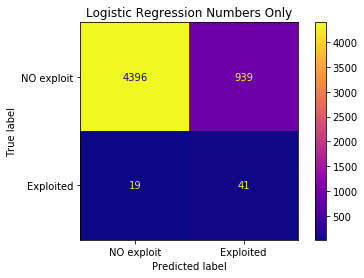

####################


              precision    recall  f1-score   support

  NO exploit       1.00      0.82      0.90      5335
   Exploited       0.04      0.68      0.08        60

    accuracy                           0.82      5395
   macro avg       0.52      0.75      0.49      5395
weighted avg       0.99      0.82      0.89      5395



In [43]:
utils.metric_evaluation(lr, X_train_num, X_test_num, y_test, 'Logistic Regression Numbers Only')

#### Naive Bayes

In [44]:
nb = GaussianNB(priors=None, 
                var_smoothing=1e-09)

In [45]:
nb.fit(X_train_num, y_train)
y_nb_num=nb.predict(X_test_num)


Confusion Matrix in array form
[[ 139 5196]
 [   0   60]]


####################


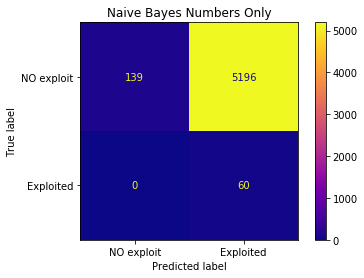

####################


              precision    recall  f1-score   support

  NO exploit       1.00      0.03      0.05      5335
   Exploited       0.01      1.00      0.02        60

    accuracy                           0.04      5395
   macro avg       0.51      0.51      0.04      5395
weighted avg       0.99      0.04      0.05      5395



In [46]:
utils.metric_evaluation(nb, X_train_num, X_test_num, y_test, title = 'Naive Bayes Numbers Only')

#### Random forest

In [47]:
rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='sqrt', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight='balanced', 
                            ccp_alpha=0.0, 
                            max_samples=None)
rf.fit(X_train_num, y_train)
y_rf_num = rf.predict(X_test_num)


Confusion Matrix in array form
[[4811  524]
 [  29   31]]


####################


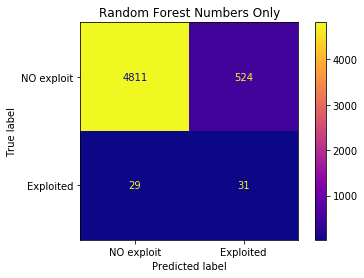

####################


              precision    recall  f1-score   support

  NO exploit       0.99      0.90      0.95      5335
   Exploited       0.06      0.52      0.10        60

    accuracy                           0.90      5395
   macro avg       0.52      0.71      0.52      5395
weighted avg       0.98      0.90      0.94      5395



In [48]:
utils.metric_evaluation(rf, X_train_num, X_test_num, y_test, title = 'Random Forest Numbers Only')

#### GBTree

In [49]:
gb = GradientBoostingClassifier(loss='deviance', 
                                    learning_rate=0.1, 
                                    n_estimators=100, 
                                    subsample=1.0, 
                                    criterion='friedman_mse', 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, 
                                    max_depth=3, 
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features='sqrt', 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='deprecated', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001, 
                                    ccp_alpha=0.0)

gb.fit(X_train_num, y_train)
y_gb_num = gb.predict(X_test_num)


Confusion Matrix in array form
[[5329    6]
 [  59    1]]


####################


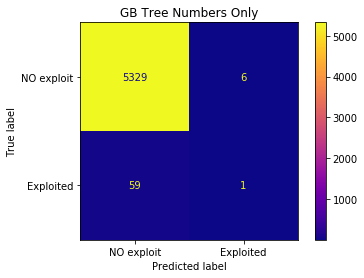

####################


              precision    recall  f1-score   support

  NO exploit       0.99      1.00      0.99      5335
   Exploited       0.14      0.02      0.03        60

    accuracy                           0.99      5395
   macro avg       0.57      0.51      0.51      5395
weighted avg       0.98      0.99      0.98      5395



In [50]:
utils.metric_evaluation(gb, X_train_num, X_test_num, y_test, title = 'GB Tree Numbers Only')

#### SVM

In [51]:
# svc = SVC( C=1.0, 
#           kernel='rbf', 
#           degree=3, 
#           gamma='scale', 
#           coef0=0.0, 
#           shrinking=True, 
#           probability=False, 
#           tol=0.001, 
#           cache_size=200, 
#           class_weight='balanced', 
#           verbose=False, 
#           max_iter=-1, 
#           decision_function_shape='ovr', 
#           break_ties=False, 
#           random_state=None)

# svc.fit(X_train_num, y_train)
# y_svc_num = svc.predict(X_test_num)
# confusion_matrix(y_test, y_svc_num)

In [52]:
#utils.metric_evaluation(svc, X_train_num, X_test_num, y_test)

#### XGBoost

adapted from here: https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html

In [53]:
bst = xgb.XGBClassifier(n_estimators=100,
                        colsample_bytree=0.9, 
                        eta=0.9, 
                        max_depth=6, 
                        num_boost_round=10,
                        subsample=0.9, 
                        n_jobs=-1)

bst.fit(X_train_num, y_train)


XGBClassifier(colsample_bytree=0.9, eta=0.9, max_depth=6, n_jobs=-1,
              num_boost_round=10, subsample=0.9)

In [54]:
y_xgb_num = bst.predict(X_test_num)

Confusion Matrix in array form
[[5324   11]
 [  55    5]]


####################


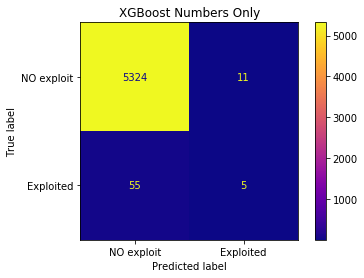

####################


              precision    recall  f1-score   support

  NO exploit       0.99      1.00      0.99      5335
   Exploited       0.31      0.08      0.13        60

    accuracy                           0.99      5395
   macro avg       0.65      0.54      0.56      5395
weighted avg       0.98      0.99      0.98      5395



In [55]:
utils.metric_evaluation(bst, X_train_num, X_test_num, y_test, title = 'XGBoost Numbers Only')

#### Putting all the plots together

Text(0.5, 1.0, 'ROC Curve for Numerical Features Only')

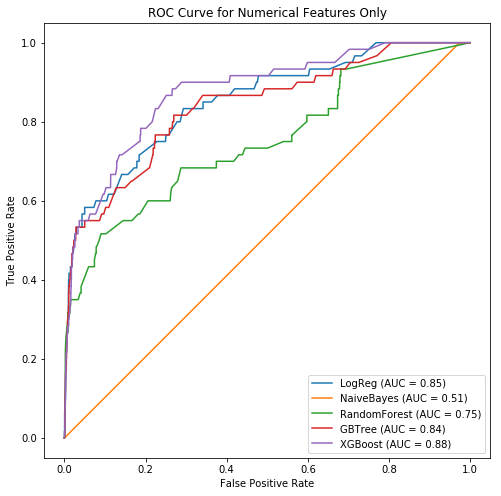

In [56]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
lr_roc = plot_roc_curve(lr, X_test_num, y_test, name='LogReg', ax=ax)
nb_roc = plot_roc_curve(nb, X_test_num, y_test, name='NaiveBayes', ax=ax)
rf_roc = plot_roc_curve(rf, X_test_num, y_test, name='RandomForest', ax=ax)
gb_roc = plot_roc_curve(gb, X_test_num, y_test, name='GBTree', ax=ax)
xgb_roc = plot_roc_curve(bst, X_test_num, y_test, name='XGBoost', ax=ax)

plt.title("ROC Curve for Numerical Features Only")

Text(0.5, 1.0, 'PRC Curve for Numerical Features')

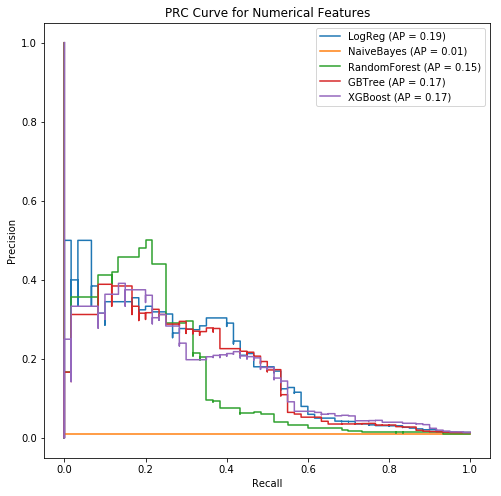

In [57]:
fig = plt.figure(figsize=(8,8))

ax = fig.gca()
lr_prc = plot_precision_recall_curve(lr, X_test_num, y_test, name='LogReg', ax=ax)
nb_prc = plot_precision_recall_curve(nb, X_test_num, y_test, name='NaiveBayes', ax=ax)
rf_prc = plot_precision_recall_curve(rf, X_test_num, y_test, name='RandomForest', ax=ax)
gb_prc = plot_precision_recall_curve(gb, X_test_num, y_test, name='GBTree', ax=ax)
xgb_prc = plot_precision_recall_curve(bst, X_test_num, y_test, name='XGBoost', ax=ax)

ax.legend(loc='upper right')
plt.title("PRC Curve for Numerical Features")

## A: Numerical Features Alone Probably Not Enough 
<br>
<br>
If we use numerical data alone, performance ranges from inaccurate to abyssimal. We are unable to provide a solution that offers enough coverage of critical cases while also being efficient. In the subsequent notebook we explore using the text data for classifiers.


## Q: Are NLP Features alone enough?

#### Logistic Regression

In [58]:
#instantiate with default params
lr_text = LogisticRegression(penalty='l2',
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight='balanced', 
                        random_state=None, 
                        solver='lbfgs', 
                        max_iter=100, 
                        multi_class='auto', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=-1, 
                        l1_ratio=None)

#fit to text only features
lr_text.fit(X_train_text, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1)

Confusion Matrix in array form
[[4114 1221]
 [  19   41]]


####################


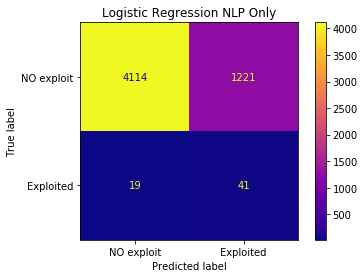

####################


              precision    recall  f1-score   support

  NO exploit       1.00      0.77      0.87      5335
   Exploited       0.03      0.68      0.06        60

    accuracy                           0.77      5395
   macro avg       0.51      0.73      0.47      5395
weighted avg       0.98      0.77      0.86      5395



In [59]:
utils.metric_evaluation(lr_text,
                        X_train_text,
                        X_test_text, 
                        y_test, 
                        title = 'Logistic Regression NLP Only')

#### Naive Bayes

In [60]:
nb_text = GaussianNB(priors=None, 
                var_smoothing=1e-09)

nb_text.fit(X_train_text.toarray(), y_train)
y_nb_text = nb_text.predict(X_test_text.toarray())

Confusion Matrix in array form
[[3563 1772]
 [  14   46]]


####################


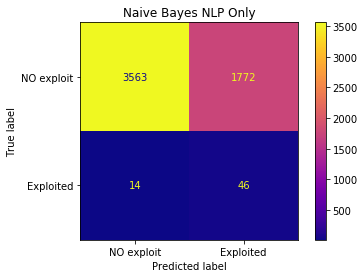

####################


              precision    recall  f1-score   support

  NO exploit       1.00      0.67      0.80      5335
   Exploited       0.03      0.77      0.05        60

    accuracy                           0.67      5395
   macro avg       0.51      0.72      0.42      5395
weighted avg       0.99      0.67      0.79      5395



In [61]:
utils.metric_evaluation(nb_text,
                        X_train_text.toarray(), 
                        X_test_text.toarray(), 
                        y_test, 
                        title = 'Naive Bayes NLP Only')

#### Random Forest

In [62]:
rf_text = RandomForestClassifier(n_estimators=100,
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='sqrt', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=None, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight='balanced', 
                            ccp_alpha=0.0, 
                            max_samples=None)

rf_text.fit(X_train_text, y_train)
y_rf_text = rf_text.predict(X_test_text)



Confusion Matrix in array form
[[5248   87]
 [  52    8]]


####################


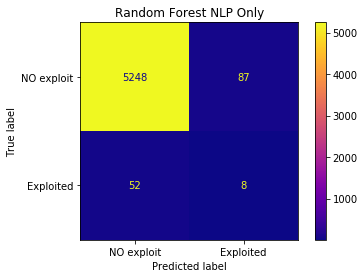

####################


              precision    recall  f1-score   support

  NO exploit       0.99      0.98      0.99      5335
   Exploited       0.08      0.13      0.10        60

    accuracy                           0.97      5395
   macro avg       0.54      0.56      0.55      5395
weighted avg       0.98      0.97      0.98      5395



In [63]:
utils.metric_evaluation(rf_text,
                        X_train_text.toarray(), 
                        X_test_text.toarray(), 
                        y_test, 
                        title = 'Random Forest NLP Only')

#### GB Tree

In [64]:
gb_text = GradientBoostingClassifier(loss='deviance', 
                                    learning_rate=0.1, 
                                    n_estimators=100, 
                                    subsample=1.0, 
                                    criterion='friedman_mse', 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, 
                                    max_depth=3, 
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features='sqrt', 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='deprecated', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001, 
                                    ccp_alpha=0.0)

gb_text.fit(X_train_text, y_train)
y_gb_text = gb_text.predict(X_test_text)


Confusion Matrix in array form
[[5331    4]
 [  60    0]]


####################


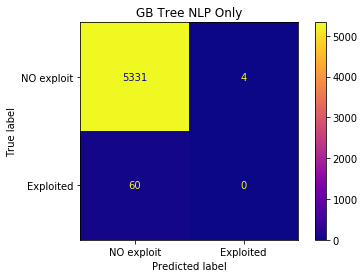

####################


              precision    recall  f1-score   support

  NO exploit       0.99      1.00      0.99      5335
   Exploited       0.00      0.00      0.00        60

    accuracy                           0.99      5395
   macro avg       0.49      0.50      0.50      5395
weighted avg       0.98      0.99      0.98      5395



In [65]:
utils.metric_evaluation(gb_text,
                        X_train_text.toarray(), 
                        X_test_text.toarray(), 
                        y_test, 
                        title = 'GB Tree NLP Only')

#### XGB

In [66]:
bst_text = xgb.XGBClassifier(n_estimators=100,
                        colsample_bytree=0.9, 
                        eta=0.9, 
                        max_depth=6, 
                        num_boost_round=10,
                        subsample=0.9, 
                        n_jobs=-1)

bst_text.fit(X_train_text, y_train)


XGBClassifier(colsample_bytree=0.9, eta=0.9, max_depth=6, n_jobs=-1,
              num_boost_round=10, subsample=0.9)

Confusion Matrix in array form
[[ 737 4598]
 [   7   53]]


####################


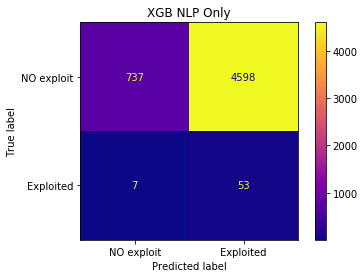

####################


              precision    recall  f1-score   support

  NO exploit       0.99      0.14      0.24      5335
   Exploited       0.01      0.88      0.02        60

    accuracy                           0.15      5395
   macro avg       0.50      0.51      0.13      5395
weighted avg       0.98      0.15      0.24      5395



In [67]:
utils.metric_evaluation(bst_text,
                        X_train_text.toarray(), 
                        X_test_text.toarray(), 
                        y_test, 
                        title = 'XGB NLP Only')

Text(0.5, 1.0, 'ROC Curve for NLP Features Only')

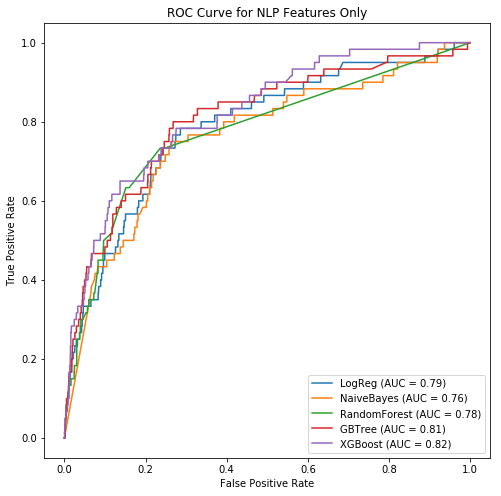

In [68]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
lr_roc = plot_roc_curve(lr_text, X_test_text, y_test, name='LogReg', ax=ax)
nb_roc = plot_roc_curve(nb_text, X_test_text.toarray(), y_test, name='NaiveBayes', ax=ax)
rf_roc = plot_roc_curve(rf_text, X_test_text, y_test, name='RandomForest', ax=ax)
gb_roc = plot_roc_curve(gb_text, X_test_text, y_test, name='GBTree', ax=ax)
xgb_roc = plot_roc_curve(bst_text, X_test_text, y_test, name='XGBoost', ax=ax)

plt.title("ROC Curve for NLP Features Only")

Text(0.5, 1.0, 'PRC Curve for Numerical Features')

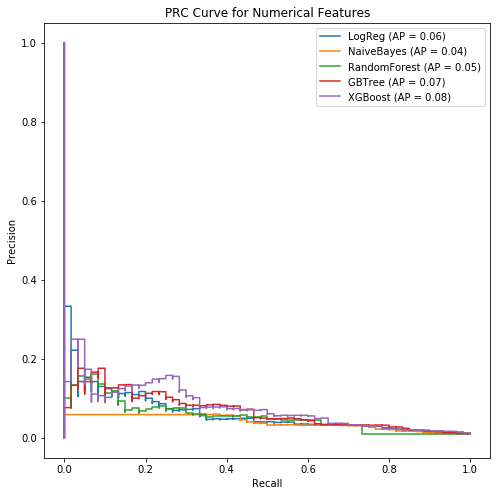

In [69]:
fig = plt.figure(figsize=(8,8))

ax = fig.gca()
lr_prc = plot_precision_recall_curve(lr_text, X_test_text, y_test, name='LogReg', ax=ax)
nb_prc = plot_precision_recall_curve(nb_text, X_test_text.toarray(), y_test, name='NaiveBayes', ax=ax)
rf_prc = plot_precision_recall_curve(rf_text, X_test_text, y_test, name='RandomForest', ax=ax)
gb_prc = plot_precision_recall_curve(gb_text, X_test_text, y_test, name='GBTree', ax=ax)
xgb_prc = plot_precision_recall_curve(bst_text, X_test_text, y_test, name='XGBoost', ax=ax)

ax.legend(loc='upper right')
plt.title("PRC Curve for Numerical Features")

### So What Happened?

It seems like numerical or NLP features alone do not give the best of results. Our 